# Semisupervised learning

In the first homework you explored the heat equation. Then in the second homework you looked into spectral clustering. For the final, we can combine them together to do semisupervised learning.

In [1]:
from typing import Tuple, Dict, Hashable

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

colors = np.array(['tab:blue', 'orange'])

First you will load the images from homework 2.

In [2]:
import os
import imageio


from scipy import ndimage

def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res = res[:((sx // fact) * (sy // fact))]
    res.shape = (sx//fact, sy//fact)
    return res


def block_max(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.histogram(ar, 1, 3, 3, labels=regions, index=np.arange(regions.max() + 1))
    res = res[:((sx // fact) * (sy // fact))]
    labels = np.zeros_like(res)
    values = [1, -1, 0]
    for i, c in enumerate(res):
        labels[i] = values[np.argmax(c)]
    labels.shape = (sx//fact, sy//fact)
    return labels
    

image_filenames = [f for f in os.listdir('images') if f.endswith('jpg')]
image_names = [os.path.splitext(f)[0] for f in image_filenames]
mask_filenames = [f'{f}.png' for f in image_names]

images = [imageio.imread(os.path.join('images', filename)) / 255 for filename in image_filenames]
masks = [imageio.imread(os.path.join('images', filename)) for filename in mask_filenames]

factor = 5
subsampled_images = []
subsampled_masks = []
for i, im in enumerate(images):
    sx, sy, _ = im.shape
    subsampled_im = np.zeros((sx // factor, sy // factor, 3))
    for c  in range(3):
        subsampled_im[:, :, c] = block_mean(im[:, :, c], factor)
    subsampled_images.append(subsampled_im)
    
    subsamples_mask = block_max(masks[i], factor)
    subsampled_masks.append(subsamples_mask)

# Commenting out for easier navigation   
#for im, m in zip(subsampled_images, masks):
#    fig, ax = plt.subplots(1, 2)
#    ax[0].imshow(im)
#    ax[1].imshow(m)
#    
#    for a in ax:
#        a.set_xticks([])
#        a.set_yticks([])
#    plt.show()  

C:\Users\Caleb\AppData\Local\Temp\ipykernel_10164\1793693956.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join('images', filename)) / 255 for filename in image_filenames]
C:\Users\Caleb\AppData\Local\Temp\ipykernel_10164\1793693956.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imageio.imread(os.path.join('images', filename)) for filename in mask_filenames]


In [3]:
from datetime import datetime


def generate_graph_from_image(image: np.ndarray, dist=5, sigma_i=0.03, sigma_X=10) -> nx.Graph:
    rows, cols, _ = image.shape
    def coord_to_node(i, j):
        return i * cols + j
    start = datetime.now()
    edges = []
    for i in range(rows):
        print(f'\rProcessed {i + 1:3d} rows in {(datetime.now() - start).total_seconds():7.3f}', end='')
        # TODO: Create an undirected weighted graph from the given image
        #       Each graph should take 10-20s to generate.
        for j in range(cols):
            for di in range(dist):
                for dj in range(-dist, dist+1):
                    if (di == 0) and (dj == 0):
                        continue
                    if di * di + dj * dj > dist * dist:
                        continue
                    if not 0 <= i + di < rows:
                        continue
                    if not 0 <= j + dj < cols:
                        continue
                    w = np.exp(-np.linalg.norm(image[i, j] - image[i + di, j + dj])**2 / sigma_i) * \
                        np.exp(-np.sqrt(di * di + dj * dj)**2 / sigma_X)
                    edges.append((coord_to_node(i, j), coord_to_node(i + di, j + dj), w))
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G


rows, cols, _ = subsampled_images[1].shape
start = datetime.now()
graphs = []
for im in subsampled_images:
    G = generate_graph_from_image(im, dist=5, sigma_i=0.03, sigma_X=10)
    print(f'\rGenerated graph with {len(G)} nodes and {len(G.edges)} edges in {(datetime.now() - start).total_seconds():6.2f} seconds.')
    graphs.append(G)

Generated graph with 7500 nodes and 277943 edges in   1.98 seconds.
Generated graph with 7500 nodes and 277943 edges in   3.93 seconds.
Generated graph with 7500 nodes and 277943 edges in   5.90 seconds.
Generated graph with 7500 nodes and 277943 edges in   7.95 seconds.
Generated graph with 7500 nodes and 277943 edges in   9.87 seconds.


## Connections to Heat Diffusion

Remember that in Heat Diffusion we were minimizing the variational quantity
$$ f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x}$$
w.r.t the norm $\|\cdot\|_{\mathbf{D}}$.

For semisupervised learning we are going to add a regression term for the label set $\ell$ that is known
$$f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x} + \frac{\lambda}{2}\sum_{i \in \ell} d_i(x_i - s_i)^2 = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x} + \frac{\lambda}{2} \|\mathbf{x}_{\ell} - \mathbf{s}_\ell\|_{\mathbf{D}}^2$$

You are given code that performs the unsupervised heat diffusion and need to add your own that incorporates the regression term.

## Discussion/Solution

In my (admittely limited) understanding of Matrix algebra, I believe the gradient of the function $f(x)$ changes to 
$$\nabla f(\textbf{x}) = \nabla \big[\frac{1}{2} \textbf{x}^\intercal L\textbf{x} + \frac{\lambda}{2}\lVert x_\ell - s_\ell \rVert _D^2\big]$$

Since the gradient operator is linear, the first term stays the same, i.e.
$$\nabla f(\textbf{x}) = L\textbf{x}  + \nabla \big[\frac{\lambda}{2}\lVert \textbf{x}_\ell - s_\ell \rVert _D^2\big]$$

We can expand the term being differentiated to
$$\frac{\lambda}{2}\lVert x_\ell - s_\ell \rVert _D^2 = \frac{\lambda}{2}\Big[ (\textbf{x}_\ell - \textbf{s}_\ell)^\intercal D (\textbf{x}_\ell - \textbf{s}_\ell) \Big]$$
$$= \frac{\lambda}{2}\Big[ \textbf{x}_\ell^\intercal D \textbf{x}_\ell - \textbf{x}_\ell^\intercal D \textbf{s}_\ell - \textbf{s}_\ell^\intercal D\textbf{x}_\ell - \textbf{s}_\ell D\textbf{s}_\ell\Big]$$

Taking the derivative of this, with respect to $\textbf{x}$, gives, 
$$\frac{\lambda}{2}\nabla \big[ \lVert \textbf{x}_\ell - \textbf{s}_\ell \rVert _{D}^2 \big] = \frac{\lambda}{2}\Big[ \textbf{x}_\ell^\intercal D + \textbf{x}_\ell^\intercal D - \textbf{s}_\ell^\intercal D - \textbf{s}_\ell^\intercal D\Big] = \lambda D(\textbf{x}_\ell -\textbf{s}_\ell)$$

Therefore, the gradient for the new energy function is 
$$\nabla f(\textbf{x}) = L\textbf{x} + \lambda D(\textbf{x}_\ell - \textbf{s}_\ell)$$

Note that we are expanding $L$ to $BWB^\intercal$. The flow through each node, $WB^\intercal x$, stays the same. So new_y isn't modified. The iteration of $\textbf{x}_{i}$, after simplification, is now
$$\textbf{x}_{i+1} = \textbf{x}_i - \frac{1}{2}\Big[ D^{-1} B \textbf{y}_t + \lambda  (\textbf{x}_{\ell, t} - s_{\ell})\Big]$$
where $\textbf{x}_{\ell, t}$ is the $t$-th iteration of the labels present. My implementation is given below, and shown for the Karate-Club Graph to have exact predictions.

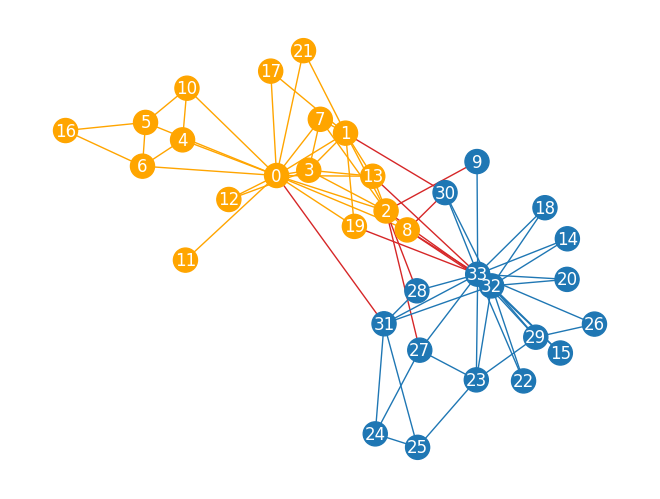

In [178]:
from typing import Tuple
import scipy.sparse

def heat_diffusion(G: nx.Graph, labels: np.ndarray, label_present: np.ndarray, lamda: float=1,
                   T: int=100) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Heat Diffusion
    
    Given a graph `G` and an initial `x_0` runs heat diffusion until $\mathcal{U}(\mathbf{x}) < \epsilon$.
    
    Parameters
    ----------
        G : nx.Graph
            Graph to run heat diffusion on.
        labels : np.ndarray
            Real numbers corresponding to the target label.
        label_present : np.ndarray
            Indicator of the corresponding node having its label revealed.
        lamda : float
            Parameter weight between the regression term and the graph regularization term
        T : int
            Number of iterations.
    
    Returns
    -------
        x : np.ndarray
            The T x n x d evolution of x_0.
        y : np.ndarray
            Flow going through each edge. Should be T x m x d
        fx: np.ndarray
            The value of U(x(t)) at each time t.
    """
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    x_0 = np.zeros((n, 1))
    assert x_0.shape[0] == n, "x_0 does not have the right shape."
    d = x_0.shape[1]
    
    degree = np.array([deg for _, deg in G.degree(weight='weight')])
    vol = degree.sum()
    D = scipy.sparse.diags(degree)
    D_inv = scipy.sparse.diags(1/degree)
    L = nx.laplacian_matrix(G)
    B = nx.incidence_matrix(G, oriented=True)
    W = scipy.sparse.diags([w if w is not None else 1 for w in nx.get_edge_attributes(G, 'weight').values()])
    
    # TODO: For semisupervised learning the variational energy function is
    #           f(x) = 0.5 * x^T L x + (lambda*0.5)*|x_{\ell} - s_{\ell}|_{D}^2
    #       Add code that computes the correct f(x) and $\nabla f(x) in order to compute $x_{t+1}$
    x_0 = np.array([x * ind for x, ind in zip(labels, label_present)])
    x = [x_0]
    y = [W @ B.T @ x_0]
    diffusion_term = (x_0 - labels).T @ D @ (x_0 - labels)
    fx = [0.5 * x_0.T @ L @ x_0 + (lamda*0.5)* diffusion_term]
    

    for i in range(T):
        x_ell = np.array([x_i*ind for x_i, ind in zip(x[-1], label_present)])
        new_x = x[-1] - 0.5 * (D_inv @ B @ y[-1] + lamda*(x_ell - labels))
        x.append(new_x)
        new_y = W @ B.T @ new_x
        y.append(new_y)
        diffusion_term = (x_ell - labels).T @ D @ (x_ell - labels)
        new_fx =0.5 * x[-1].T @ L @ x[-1] + (lamda*0.5)* diffusion_term
        fx.append(new_fx)

    
    x = np.array(x)
    y = np.array(y)
    fx = np.array(fx)
    return x, y, fx


karate = nx.karate_club_graph()
nx.set_edge_attributes(karate, 1, 'weight')
karate_labels = np.array([1 if c == 'Mr. Hi' else -1 for v, c in karate.nodes(data='club')]).reshape(-1, 1)
karate_labels_present = np.zeros_like(karate_labels)
karate_labels_present[0] = 1
karate_labels_present[33] = 1
lamda = 1
x, y, fx = heat_diffusion(karate, karate_labels, karate_labels_present, lamda)

karate_predicted_label = (x[-1] >= 0).flatten().astype(int)
node_color = colors[karate_predicted_label]
edge_color = [colors[karate_predicted_label[u]] if karate_predicted_label[u] == karate_predicted_label[v] else 'tab:red' for u, v in karate.edges]

pos = nx.spring_layout(karate)
pc = nx.draw(karate, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, font_color='white')
plt.show()

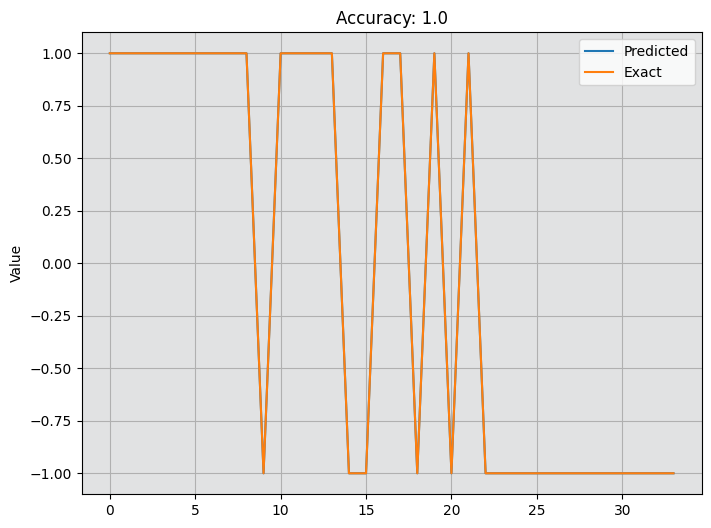

In [179]:
fig, axs = plt.subplots(1,1, figsize = (8, 6))

#The scaling and translation is just to show the prediction
#has the same shape as the exact

accuracy = 1 - np.linalg.norm((karate_predicted_label*2-1) - karate_labels.T)/np.linalg.norm(karate_predicted_label*2-1)
axs.plot(karate_predicted_label*2-1, label = 'Predicted')
axs.plot(karate_labels, label = 'Exact')
axs.legend()
axs.set_title(f'Accuracy: {accuracy}')
axs.grid(True)
axs.set_ylabel("Value")
axs.set_facecolor("#e1e2e3")
plt.show()

Now it is time to see how the accuracy is affected by the number of known labels.

In [187]:
min_revealed = 5
step_revealed = 5
max_revealed = 100
lamda = 1

final_fxs = []
predcted_xs_all = []
for G, labels in zip(graphs, subsampled_masks):
    labels = labels.flatten()
    nodes = np.array(G.nodes)
    np.random.shuffle(nodes)
    labels_present = np.zeros_like(labels)
    # TODO: Nodes have been shuffled so you can randomly select nodes to reveal.
    #       Starting from `min_revealed` run semisupervised learning and
    #       report in plots how the final fx responds and how accuracy changes wrt the number of revealed points.
    fxs = []
    prediction = []
    num_revealed_nodes = min_revealed
    while num_revealed_nodes < max_revealed:
        nodes_revealed = nodes[:num_revealed_nodes]
        labels_present[nodes_revealed] = 1
        
        x, y, fx = heat_diffusion(G, labels.astype(float), labels_present.astype(float), lamda)
        fxs.append(fx[-1])
        predicted = np.round(np.clip(x[-1], -1, 1))
        prediction.append(np.linalg.norm(predicted - labels)/np.linalg.norm(predicted))
        num_revealed_nodes+= step_revealed
    predcted_xs_all.append(prediction)
    final_fxs.append(fxs)

    

Here I am plotting the last energy values for the number of given nodes for each subsampled mask. I'm not entirely sure that this is correct, as it seems the values are $\textit{much}$ larger than anticipated (though they grow linearly). It seems that $\textit{generally}$, the accuracy of predicting lables increses with the number of nodes, but this might be a little inaccurate due to my handling of the predicted values (I am clamping the value range to [-1, 1], then rounding to the nearest integer). The precedure for the karate graph was more straight forward: since we only had two prediction values, we could just do a check if the value was greater than 0.5. Since we have 3 prediction labels, the procedure is different. Though I believe my results are pretty good for picking around $1\%$ of nodes.

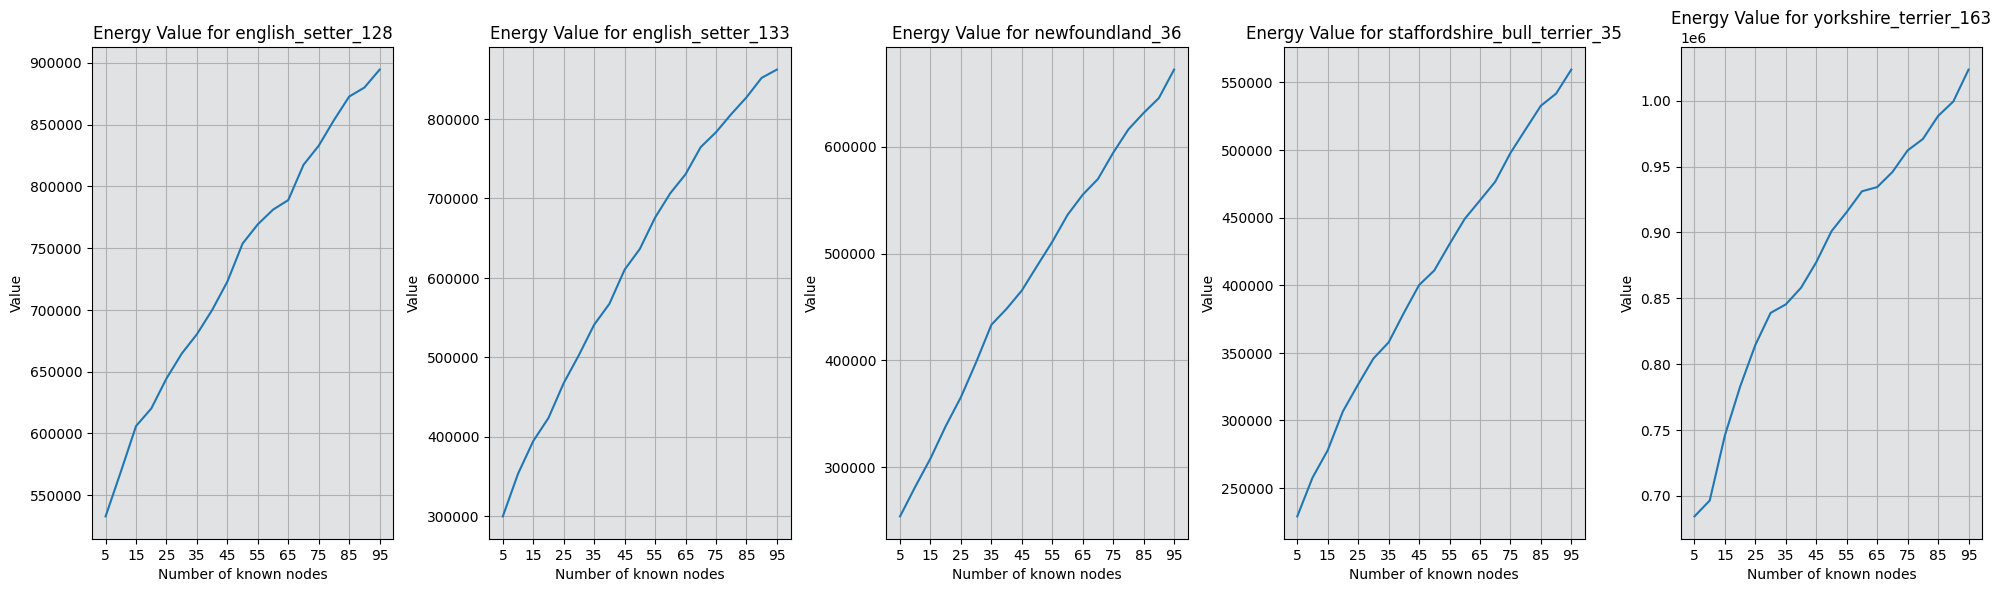

In [194]:
fig, axs = plt.subplots(1, 5, figsize = (20, 6))
axs = axs.flat
for i, fxs_list in enumerate(final_fxs):
    axs[i].plot(fxs_list)
    axs[i].set_title(f'Energy Value for {mask_filenames[i][:-4]}')
    axs[i].grid(True)
    axs[i].set_xticks(np.arange(0, 1+len(fxs_list), 2))
    axs[i].set_xticklabels(np.arange(1, 1+len(fxs_list), 2)*5)
    axs[i].set_ylabel("Value")
    axs[i].set_facecolor("#e1e2e3")
    axs[i].set_xlabel("Number of known nodes")
plt.tight_layout(pad = 1)

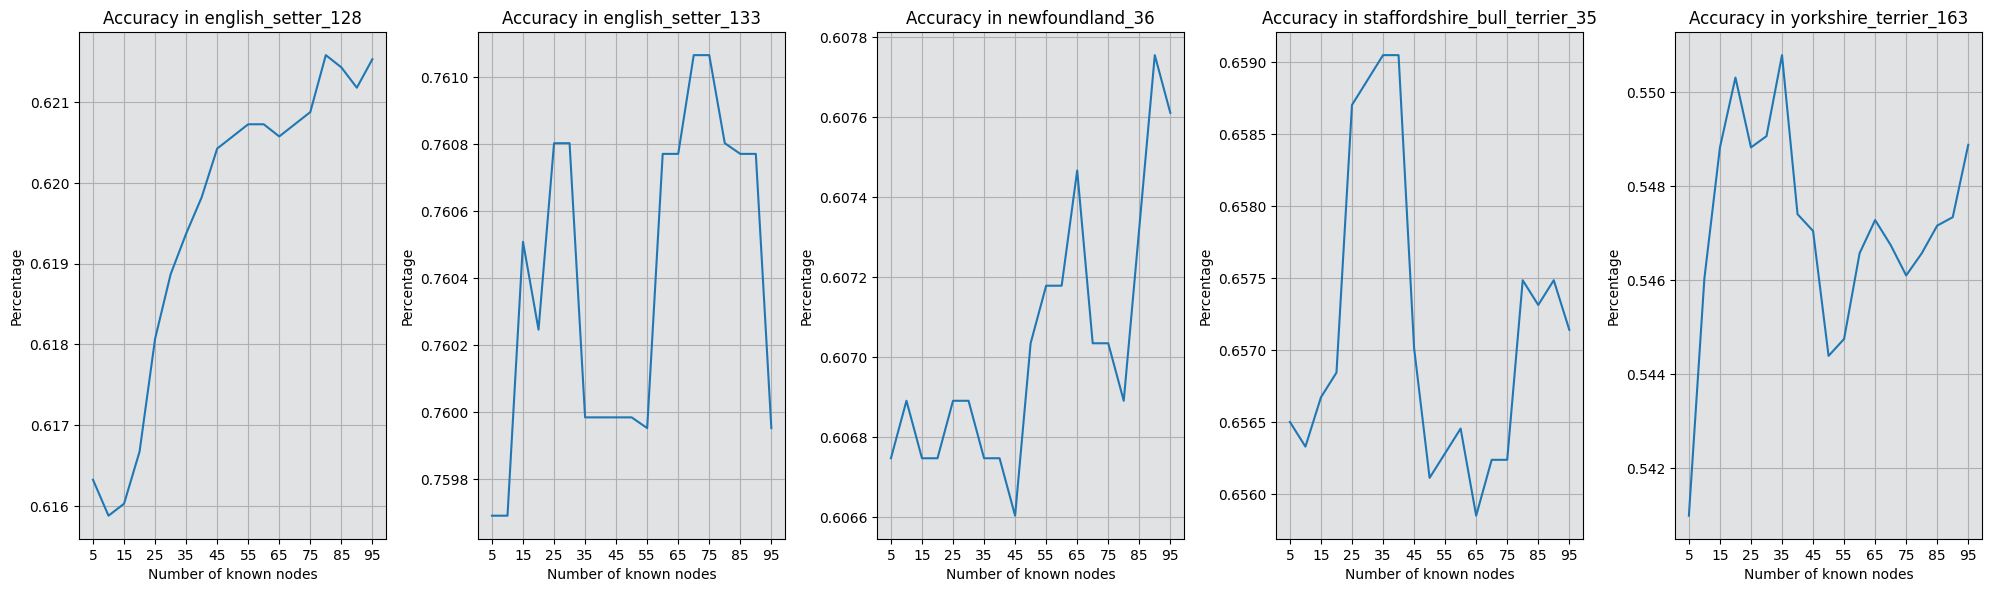

In [192]:
fig, axs = plt.subplots(1, 5, figsize = (20, 6))
axs = axs.flat
xticks_positions = np.arange(1, len(predcted_xs_all[0])+1)*5
for i, xs in enumerate(predcted_xs_all):
    axs[i].plot(1-np.array(xs))
    axs[i].set_title(f'Accuracy in {mask_filenames[i][:-4]}')
    axs[i].grid(True)
    axs[i].set_xticks(np.arange(0, len(xs), 2))
    axs[i].set_xticklabels(np.arange(1, len(xs)+1, 2)*5)
    axs[i].set_ylabel("Percentage")
    axs[i].set_facecolor("#e1e2e3")
    axs[i].set_xlabel("Number of known nodes")
plt.tight_layout(pad = 1)